### Cost Functions in Deep Learning — A Gentle, Bio-flavored Intro

This notebook gives a short tour of three essential cost (loss) functions:

- **Mean Squared Error (MSE)** — common for regression (e.g., predicting tumor size from biomarkers).
- **Hinge Loss** — promotes confident margins in binary classification.
- **Cross-Entropy** — the workhorse for probabilistic classification (e.g., disease vs. healthy).


### Imports

In [99]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
# For reproducibility
rng = np.random.default_rng(42)

### 1) Mean Squared Error (MSE)

**Idea:** MSE measures the *average of the squared differences* between predictions and true values.  
By squaring the error, **large mistakes are punished much more** than small ones.

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \big( y_i - \hat{y}_i \big)^2
$$

**Example:** Predicting **tumor volume (cm³)** from a single biomarker. We’ll make synthetic data where the true relationship is roughly linear with noise, and we’ll compare **predicted** vs **actual** tumor volumes.


In [101]:
# --- Synthetic data: tumor volume regression ---
n = 30
biomarker = rng.uniform(0, 10, size=n)
true_tumor_volume = 2.0 * biomarker + 5.0 + rng.normal(0, 3.0, size=n)  # linear-ish with noise

# A simple (imperfect) model: underestimates slope a bit and has bias
pred_tumor_volume = 1.6 * biomarker + 6.0

# Compute MSE
errors = true_tumor_volume - pred_tumor_volume
mse = np.mean(errors**2)

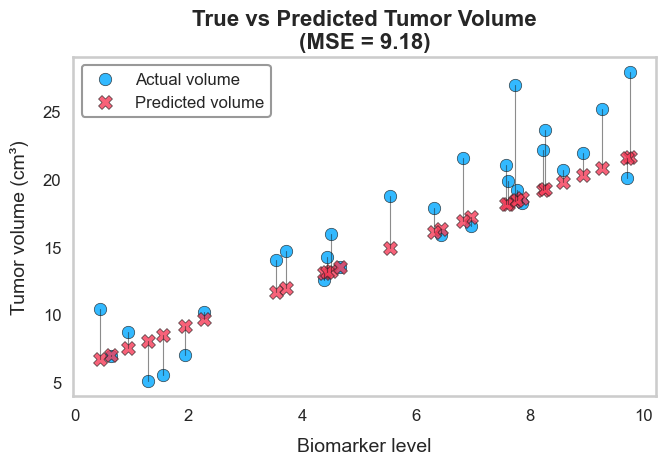

In [102]:
plt.figure(figsize=(7,5))

# Actual values
plt.scatter(
    biomarker, true_tumor_volume, 
    color="#00a8ff", edgecolor="k", linewidths=0.5, s=80, 
    label="Actual volume", alpha = 0.8
)

# Predicted values
plt.scatter(
    biomarker, pred_tumor_volume, 
    marker="X", color="#f53b57", s=100, edgecolor="k", linewidths=0.5, 
    label="Predicted volume", alpha = 0.8
)

# Error lines (transparent gray for readability)
for x, y_true, y_pred in zip(biomarker, true_tumor_volume, pred_tumor_volume):
    plt.plot([x, x], [y_pred, y_true], color="k", alpha=0.5, linewidth=0.8)

# Titles and labels
plt.title(f"True vs Predicted Tumor Volume\n(MSE = {mse:.2f})", fontsize=16, weight="bold")
plt.xlabel("Biomarker level", fontsize=14 , labelpad=10)
plt.ylabel("Tumor volume (cm³)", fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', which='both', length=5, width=1, direction='out')

# Legend
plt.legend(
    frameon=True, fontsize=12, loc="best",
    fancybox=True, framealpha=0.8, edgecolor="gray"
)

# Tight layout
plt.tight_layout()
plt.grid(False)
plt.show()

**What’s happening above?**  
- Dots = **actual** tumor volumes; crosses = **predicted** volumes.  
- Each vertical line shows the **error** (difference between actual and predicted).  
- The MSE is the *average of the squared errors*. Squaring makes **big mistakes count a lot**, so the model is encouraged to reduce large errors in particular.


### 2) Hinge Loss (Margin-based classification)

**Idea:** Hinge loss encourages predictions that are not only correct, but **confidently** correct — far from the decision boundary.  
Even if a point is classified correctly, if it’s **too close** to the boundary, there’s still some penalty.

$$
\text{Hinge}(y_i, f(x_i)) = \max \big( 0, \, 1 - y_i \cdot f(x_i) \big)
$$

$$
L = \frac{1}{N} \sum_{i=1}^{N} \max \big( 0, \, 1 - y_i \cdot f(x_i) \big)
$$

**Example:** Classify **benign (0)** vs **malignant (1)** cases from two simple biomarkers. We’ll visualize a linear decision boundary and margins.


In [103]:
# --- Synthetic data: benign (0) vs malignant (1) ---
m = 60
# Two clusters
benign = rng.normal(loc=[2.0, 2.0], scale=0.9, size=(m//2, 2))
malig  = rng.normal(loc=[5.0, 5.0], scale=1.0, size=(m//2, 2))

X = np.vstack([benign, malig])
y = np.hstack([np.zeros(len(benign)), np.ones(len(malig))])

# We'll handcraft a linear decision boundary: w·x + b = 0
w = np.array([1.0, 1.0])
b = -6.0

# Signed distance to boundary (scaled by ||w||)
w_norm = np.linalg.norm(w)
signed_dist = (X @ w + b) / w_norm

# SVM-style hinge loss for labels in {-1, +1}
y_pm = np.where(y==1, 1, -1)
hinge_losses = np.maximum(0.0, 1 - y_pm * (X @ w + b) / w_norm)
avg_hinge = np.mean(hinge_losses)

# Visualization: points, boundary, and margins
xx = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, 100)
# For line w1*x + w2*y + b = 0  -> y = (-w1*x - b)/w2
yy = (-w[0]*xx - b)/w[1]

# Margins: w·x + b = ±1 -> y = (-w1*x - b ± ||w||)/w2
yy_m1 = (-w[0]*xx - (b + w_norm))/w[1]
yy_p1 = (-w[0]*xx - (b - w_norm))/w[1]

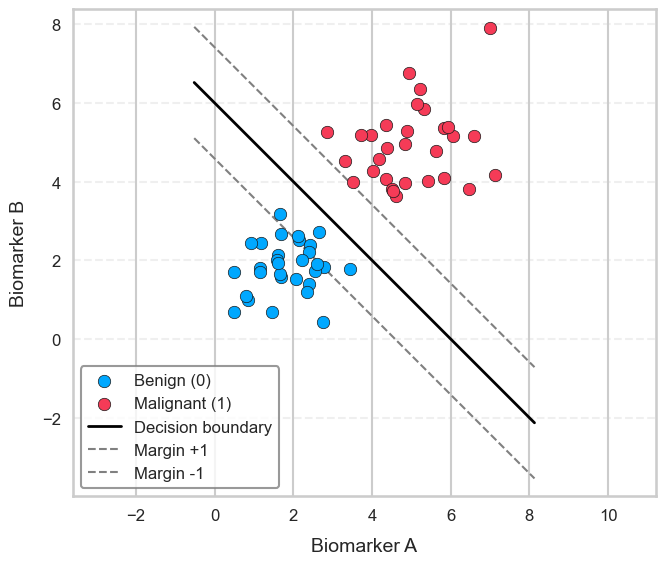

In [104]:
plt.figure(figsize=(7,6))

# Benign (class 0)
plt.scatter(
    benign[:,0], benign[:,1], 
    label="Benign (0)", 
    color="#00a8ff", s=80, edgecolor="k", linewidths=0.5, zorder=3
)

# Malignant (class 1)
plt.scatter(
    malig[:,0], malig[:,1], 
    label="Malignant (1)", 
    color="#f53b57", s=80, edgecolor="k", linewidths=0.5, zorder=3
)

# Decision boundary
plt.plot(xx, yy, color="black", linewidth=2, label="Decision boundary", zorder=2)

# Margins
plt.plot(xx, yy_m1, linestyle="--", color="gray", linewidth=1.5, label="Margin +1", zorder=1)
plt.plot(xx, yy_p1, linestyle="--", color="gray", linewidth=1.5, label="Margin -1", zorder=1)

# Titles and labels
plt.xlabel("Biomarker A", fontsize=14, labelpad=10)
plt.ylabel("Biomarker B", fontsize=14, labelpad=10)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis="both", which="both", length=5, width=1, direction="out")

# Legend
plt.legend(
    frameon=True, fontsize=12, loc="best", 
    fancybox=True, framealpha=0.8, edgecolor="gray"
)

# Grid (optional, horizontal only for subtle polish)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Equal aspect ratio
plt.xlim(-3,8)
plt.axis("equal")

plt.tight_layout()
plt.show()


**What’s happening above?**  
- We drew a **decision boundary** and two **margins** (dashed lines).  
- **Hinge loss** penalizes points on the wrong side **and** points that are correct but **too close** to the boundary.  
- This encourages the model to create a **wider, safer margin**, leading to more confident decisions (helpful in medical settings).


### 3) Cross-Entropy (Probability-focused classification)

**Idea:** Cross-entropy compares the **true label** with the model’s **predicted probability**.  
It **rewards confident, correct predictions** and **penalizes confident, wrong ones** most heavily.

$$
\text{BCE} = - \frac{1}{N} \sum_{i=1}^{N} \Big[ y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \Big]
$$


**Example:** Predict whether a sample is **disease** or **healthy** from features. We’ll simulate a list of model probabilities and show how the loss changes with confidence.


In [105]:
# Example predicted probabilities for disease
probs = np.array([0.95, 0.80, 0.60, 0.55, 0.40, 0.10, 0.01])  # predicted P(disease)
true  = np.array([1,    1,    1,    0,    0,    0,    1])    # ground truth (1=disease, 0=healthy)

# Binary cross-entropy per sample
eps = 1e-12  # to avoid log(0)
bce = -(true * np.log(probs + eps) + (1 - true) * np.log(1 - probs + eps))
avg_bce = np.mean(bce)

# X-axis positions
x = np.arange(len(probs))

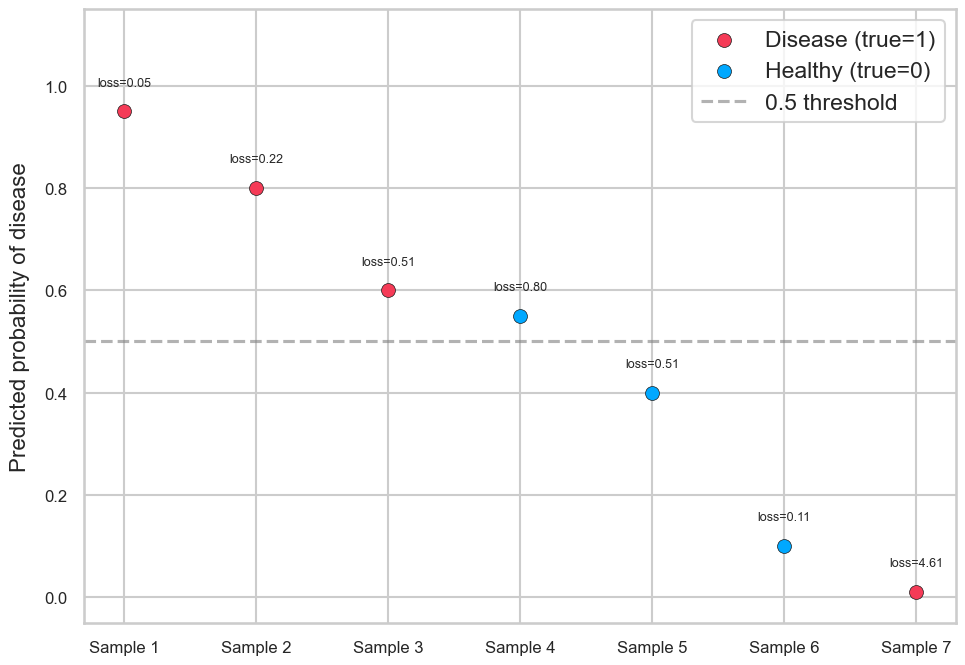

In [106]:
plt.figure(figsize=(10,7))

# Plot each sample with color by true label
for i, (p, y_i, l) in enumerate(zip(probs, true, bce)):
    if y_i == 1:
        plt.scatter(i, p, color="#f53b57", s=100, edgecolor="k", linewidths=0.5, label="Disease (true=1)" if i==0 else "")
    else:
        plt.scatter(i, p, color="#00a8ff", s=100,edgecolor="k", linewidths=0.5, label="Healthy (true=0)" if i==3 else "")
    
    # Annotate each point with its loss value
    plt.text(i, p + 0.05, f"loss={l:.2f}", ha="center", fontsize=9)

# Add probability threshold line
plt.axhline(0.5, color="gray", linestyle="--", alpha=0.6, label="0.5 threshold")

# Formatting
plt.xticks(x,[f"Sample {i+1}" for i in x], fontsize=12 )
plt.yticks(fontsize=12 )
plt.ylim(-0.05, 1.15)
plt.ylabel("Predicted probability of disease",fontsize=16, labelpad=10)
plt.legend()
plt.tight_layout()
plt.show()

**What’s happening above?**  
- Each bar is the model’s **predicted probability of disease** for one sample.  
- The text shows the **true label** and the **cross-entropy loss** for that sample.  
- Notice:  
  - **High probability & correct** → small loss (great!).  
  - **High probability & wrong** → very large loss (bad!).  
  - **Low-confidence guesses** sit somewhere in the middle.  
  
Cross-entropy is the standard choice when we want the model to output **good probabilities**, not just labels.


### Wrap-up

- **MSE** (regression): averages **squared errors** → big mistakes hurt a lot.  
- **Hinge loss** (margin-based binary classification): penalizes **wrong** and **too-close** points to encourage **confident margins**.  
- **Cross-entropy** (probabilistic classification): rewards **confident & correct** predictions, punishes **confident & wrong** the most.

In practice:
- Use **MSE/MAE** for continuous outcomes (e.g., tumor size, expression levels).  
- Use **Cross-Entropy** for classification (e.g., disease vs healthy, subtype prediction).  
- Consider **margin-based losses** like hinge when you care about **clear decision boundaries**.


